# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [41]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import re
from keras.callbacks import ModelCheckpoint, LambdaCallback
from PIL import Image

In [42]:
import platform
print(platform.system())

Linux


In [43]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [44]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1) DATA PRE-PROCESSING

a) Load in kaggle data labels + image file paths

b) combine kaggle data labels and image file paths into one dataframe

c) load in the extra 486 image file paths

d) extract the speed and angle labels from the file path names

e) store that extra data in a pandas df and do the value normalisation

f) merge the kaggle and extra data dfs

g) EDA

h) convert the images to numerical RGB feature maps

i) split data into training-validation sets

j) data augmentation applied to training set

### 1a) load in kaggle data labels + image file paths

In [45]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
# labels_file_path = '/home/ppytr13/machine-learning-in-science-ii-2025/training_norm.csv' # tyler hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [46]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # OG data ben hpc file path (mlis2 cluster)
# image_folder_path = '/home/ppytr13/machine-learning-in-science-ii-2025//training_data/training_data'
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [47]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [48]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


### 1b) Combine the kaggle labels and image file paths into one dataframe

In [49]:
kaggle_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
kaggle_df['speed'] = kaggle_df['speed'].round(6) # to get rid of floating point errors

In [50]:
kaggle_df.tail()

,angle,speed,image_file_paths
image_id,,,
13794,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13794.png
13795,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13795.png
13796,0.5625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13796.png
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13798.png


In [51]:
kaggle_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) load in the extra 486 labels image file paths

In [52]:
petrudata_folder_path = '/home/apyba3/petru_data'
bendata_folder_path = '/home/apyba3/bendata_1st_set'

In [53]:
def extract_filepaths(extradata_folderpath):
    extradata_file_paths = [
    os.path.join(extradata_folderpath, f)
    for f in os.listdir(extradata_folderpath)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]
    return extradata_file_paths

### 1d) extract the speed and angle labels from the file path names

image file path name follows the pattern: `randomnumber_angle_speed`

In [54]:
def loadin_extradata(extradata_folderpath):
    extracted_filepaths = extract_filepaths(extradata_folderpath)
    # Regex pattern to extract angle and speed values
    pattern = r'(\d+)_(\d+)_(\d+)\.png'  # Fixed pattern to capture groups correctly

    angle_value = []
    speed_value = []

    # Loop through file paths and extract angle and speed values
    for file_path in extracted_filepaths:
        match = re.search(pattern, file_path)
        if match:
            # Extract random number, angle, and speed values
            random_number = match.group(1)
            angle_value.append(int(match.group(2)))
            speed_value.append(int(match.group(3)))
        else:
            print(f"No match found for file: {file_path}")

    return angle_value, speed_value

checking it has stored the labels correctly (check if the angle_value order matches that of the file path)

### 1e) store that extra data in a pandas df and do the value normalisation

In [55]:
def create_df_and_normalisation(folder_path):
    max_image_id = len(loadin_extradata(folder_path)[0])
    df = pd.DataFrame(
        {
            'angle': loadin_extradata(folder_path)[0],
            'speed': loadin_extradata(folder_path)[1],
            'image_file_paths': extract_filepaths(folder_path)
        }
    )

    df.loc[df['speed'] > 0, 'speed'] = 1
    df['angle'] = (df['angle'] - 50)/80
    return df

def combine_dfs_add_imageid(df1, df2):
    combined_df = pd.concat([df1, df2], ignore_index=True)
    combined_df.index = pd.RangeIndex(start=13799, stop=13799 + len(combined_df), step=1)
    combined_df.index.name = 'image_id'
    return combined_df

bendata_df = create_df_and_normalisation(bendata_folder_path)
petrudata_df = create_df_and_normalisation(petrudata_folder_path)

combinedextradata_df = combine_dfs_add_imageid(bendata_df, petrudata_df)
display(combinedextradata_df.tail())

,angle,speed,image_file_paths
image_id,,,
16402,0.3125,1,/home/apyba3/petru_data/1712922464963_75_35.png
16403,0.5625,1,/home/apyba3/petru_data/1712918948764_95_35.png
16404,0.3125,1,/home/apyba3/petru_data/1712921132962_75_35.png
16405,0.7500,1,/home/apyba3/petru_data/1712917893422_110_35.png
16406,0.1250,1,/home/apyba3/petru_data/1712918494936_60_35.png


### 1f) merge the kaggle and extra data dfs

In [56]:
merged_df = pd.concat([kaggle_df, combinedextradata_df])

### 1g) check for corrupted images and get rid of them

In [57]:
def validate_image_files(dataframe):
    """
    Check each image file in the dataframe and return a new dataframe with only valid files.
    Also prints information about invalid files.
    """
    valid_rows = []
    invalid_files = []
    
    print(f"Checking {len(dataframe)} image files...")
    
    for index, row in dataframe.iterrows():
        path = row['image_file_paths']
        
        # # Print every 100 files to show progress
        # if len(valid_rows) % 100 == 0 and len(valid_rows) > 0:
        #     print(f"Processed {len(valid_rows) + len(invalid_files)} files, {len(valid_rows)} valid...")
        
        try:
            # Basic file checks
            if not os.path.exists(path):
                # print(f"File does not exist: {path}")
                invalid_files.append(path)
                continue
                
            if os.path.getsize(path) == 0:
                # print(f"File is empty: {path}")
                invalid_files.append(path)
                continue
            
            # Try to open the image with PIL to verify it's valid
            with Image.open(path) as img:
                # Just accessing img.size will verify the image can be read
                width, height = img.size
            
            # If we get this far, the image is valid
            valid_rows.append(row)
                
        except Exception as e:
            print(f"Error with {path}: {e}")
            invalid_files.append(path)
    
    # Create a new dataframe with only valid rows
    valid_df = pd.DataFrame(valid_rows)
    
    print(f"\nValidation complete: {len(valid_df)} valid files, {len(invalid_files)} invalid files")
    
    # if invalid_files:
    #     print("\nFirst few invalid files:")
    #     for path in invalid_files[:5]:
    #         print(f"  - {path}")
    
    return valid_df

# Run the validation
valid_df = validate_image_files(merged_df)

Checking 16401 image files...

Validation complete: 16373 valid files, 28 invalid files


### 1h) EDA

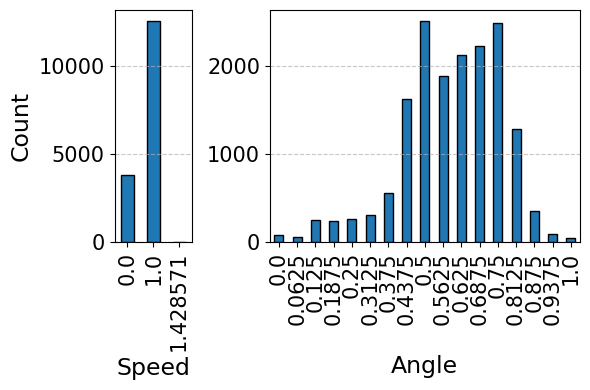

In [58]:
# Get value counts
speed_counts = valid_df['speed'].value_counts().sort_index()
angle_counts = valid_df['angle'].value_counts().sort_index()

# Create subplots with custom width ratios
fig, axes = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'width_ratios': [1,4]})  # Speed plot narrower

# Plot speed
speed_counts.plot(kind='bar', edgecolor='black', ax=axes[0])
# axes[0].set_title('Speed', fontsize=15)
axes[0].set_xlabel('Speed', fontsize=17)
axes[0].set_ylabel('Count', fontsize=17)
axes[0].tick_params(axis='both', labelsize=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot angle
angle_counts.plot(kind='bar', edgecolor='black', ax=axes[1])
# axes[1].set_title('Angle', fontsize=15)
axes[1].set_xlabel('Angle', fontsize=17, labelpad=22)
# axes[1].set_ylabel('Count', fontsize=17)
axes[1].tick_params(axis='both', labelsize=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save
plt.tight_layout()
plt.savefig('speed_angle_distribution.pdf', format='pdf')
plt.show()

In [59]:
valid_df.value_counts('speed')

speed
1.000000    12553
0.000000     3819
1.428571        1
Name: count, dtype: int64

note: imbalance datset

we want to remove the row containing the erroneous 1.428571 speed value

In [60]:
cleaned_df = valid_df[valid_df['speed'] != 1.428571]

In [61]:
cleaned_df.value_counts('speed')

speed
1.0    12553
0.0     3819
Name: count, dtype: int64

### 1i) convert images to numerical RGB feature maps

In [62]:
BATCH_SIZE = 32

In [63]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalise pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

lets check and see if what we have done works

In [64]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


### 1j) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [65]:
# 90-10 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.9 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [66]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 460, validation size: 52


### 1k) Data Augmentation applied to training set

- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Horizontal Flip



In [67]:
def augment_image(image, label):
  seed = (6, 9)
  image = tf.image.stateless_random_brightness(image, 0.2, seed)
  image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_flip_left_right(image, seed)
  return image, label

# Create a dataset of augmented images from the original train_dataset
augmented_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate the original and augmented datasets
train_dataset = train_dataset.concatenate(augmented_dataset)

# Shuffle the combined dataset
train_dataset = train_dataset.shuffle(buffer_size=len(cleaned_df))

In [68]:
angle_list = []

for image_batch, label_batch in train_dataset:
    angle_list.extend(label_batch.numpy())  # add all 32 values from the batch

angle_distribution = pd.Series(angle_list).value_counts().sort_index()
print(angle_distribution)


0.0     6866
1.0    22574
Name: count, dtype: int64


count how many images are in the training set - 22016 with no extradata and 80-20 split

In [69]:
total_images = 0
for image_batch, _ in train_dataset:
    total_images += image_batch.shape[0]  # Add the batch size

print(f"Total number of images in train_dataset: {total_images}")

Total number of images in train_dataset: 29440


checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1


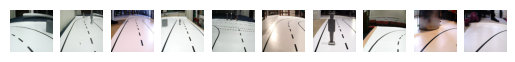

In [70]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in train_dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) CLASSIFICATION SPEED Model Building - MobNetV3Small Transfer Learning

### 2a) Set up model architecture

In [71]:
dropoutrate = 0.2
input_shape = (224,224,3)
num_classes = 1 # we're only predicting the prob of the positive class

In [72]:
mobnetv3small = tf.keras.applications.MobileNetV3Small(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

model = tf.keras.Sequential([
  mobnetv3small,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

mobnetv3small.trainable = False  # freeze mobnetv3small layers

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 576)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               147712    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

compile the model

In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

### 2c) train the model with the mobnetv3small layers frozen

In [74]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        
        # Initialize best value based on mode
        self.mode = mode
        if mode == 'min':
            self.best = float('inf')
            self.monitor_op = lambda current, best: current < best
        else:  # 'max'
            self.best = float('-inf')
            self.monitor_op = lambda current, best: current > best
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        
        if current is None:
            if self.verbose > 0:
                print(f"Warning: {self.monitor} not found in logs")
            return
            
        if self.save_best_only:
            if self.monitor_op(current, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} improved from {self.best:.4f} to {current:.4f}")
                    print(f"Saving model to {self.filepath}")
                self.best = current
                
                # Use direct model.save() without extra parameters
                try:
                    self.model.save(self.filepath)
                except Exception as e:
                    print(f"Error saving model: {e}")
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch+1}: saving model to {self.filepath}")
            try:
                self.model.save(self.filepath)
            except Exception as e:
                print(f"Error saving model: {e}")


In [75]:
# # Define checkpoint directory and create it if it doesn't exist
# checkpoint_dir = '/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Define checkpoint filepath
# checkpoint_filepath = os.path.join(checkpoint_dir, '50epochs_frozen_mobnetv3smallcheckpoint.keras')

# # Create custom checkpoint callback
# custom_checkpoint = CustomModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )

# # Define epoch callback 
# epoch_callback = LambdaCallback(
#     on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
#     on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
# )

# # Training with callbacks
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=50,
#     callbacks=[custom_checkpoint, epoch_callback]
# )

In [ ]:
# Define checkpoint directory and create it if it doesn't exist
checkpoint_dir = '/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define checkpoint filepath for the finetuned model
checkpoint_filepath = os.path.join(checkpoint_dir, 'frozentrain_50epochs_mobnetv3small_classif_checkpoint.keras')

# Use the existing CustomModelCheckpoint class (no need to redefine it)
# Just create a new instance with the updated filepath
custom_checkpoint = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Define epoch callback 
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True,  # This loads the best weights into model memory when stopping
    verbose=1
)

# Train with both callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[custom_checkpoint, epoch_callback, early_stopping]
)

In [39]:
# After training is complete
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(history, save_path=None):
    """
    Create a professional-looking loss curve plot with training and validation curves.
    
    Args:
        history: The history object returned by model.fit()
        save_path: Path to save the plot (without extension)
    """
    # Create figure with appropriate size
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Plot training & validation loss on the same figure
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], 'o-', color='blue', linewidth=2, 
            markersize=4, label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 's-', color='red', linewidth=2, 
            markersize=4, label='Validation Loss')
    
    # Add title and labels
    plt.title('Model Training Performance', fontsize=16, pad=15)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    
    # Apply your specific styling with legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14, loc='lower right')  # Legend to distinguish between lines
    plt.minorticks_on()
    plt.tick_params(axis='both', which='minor', length=4, color='gray', labelsize=14)
    plt.tick_params(axis='both', which='major', length=6, color='black', labelsize=14)
    plt.tick_params(top=True, right=True, direction='in', length=6)
    plt.tick_params(which='minor', top=True, right=True, direction='in', length=4)
    
    # Tighten layout
    plt.tight_layout()
    
    # Save the plot in both formats if a path is provided
    if save_path:
        plt.savefig(f"{save_path}.pdf", bbox_inches='tight')
        plt.savefig(f"{save_path}.png", bbox_inches='tight', dpi=300)
        print(f"Loss curves saved to {save_path}.pdf and {save_path}.png")
    
    plt.show()

# Example usage:
# After training completes
# loss_plot_path = os.path.join(checkpoint_dir, 'loss_curves')
# plot_loss_curves(history, save_path=loss_plot_path)

save the full model

In [ ]:
# Save the final model
model_path = '/home/apyba3/PICAR-autopilot/autopilot/models/BenTyler_extradata_v3small/extrabendata_50epoch_frozentrain_v3small_speedclassif.keras'
model.save(model_path)
print(f"Final model saved to {model_path}")

Final model saved to /home/apyba3/PICAR-autopilot-1/autopilot/models/BenTyler_MLiSards/50epochs_frozen_mobnetv3small_classification_model.keras


save model weights

In [ ]:
model.save_weights('/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/weights/extrabendata_50epoch_frozentrain_speedclassif.weights.keras')

clear keras session

In [35]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [32]:
dropoutrate = 0.2
input_shape = (224,224,3)
num_classes = 1 # we're only predicting the prob of the positive class

In [33]:
# Step 2: Rebuild the model in EXACTLY the same state as when weights were saved
mobnetv3small = tf.keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Create model with the SAME architecture as when saving
model = tf.keras.Sequential([
  mobnetv3small,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

# IMPORTANT: Set trainable to False BEFORE loading weights
# This matches the state when weights were saved
mobnetv3small.trainable = False

# Step 3: Compile the model
# The optimizer doesn't need to match, but having it compiled is important
model.compile(
    optimizer='adam',  # Doesn't need to match original
    loss='binary_crossentropy',  # Use your original loss function
    metrics=['accuracy']  # Use your original metrics
)

# Step 4: Load the weights
weights_path = '/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/weights/extrabendata_50epoch_frozentrain_speedclassif.weights.keras'
model.load_weights(weights_path)

# Step 5: NOW you can set trainable to True for fine-tuning
mobnetv3small.trainable = True

# Step 6: Re-compile with appropriate learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Verify model structure
model.summary()

print("Successfully loaded weights and prepared model for fine-tuning!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

Initiate fine-tuning training

In [36]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        
        # Initialize best value based on mode
        self.mode = mode
        if mode == 'min':
            self.best = float('inf')
            self.monitor_op = lambda current, best: current < best
        else:  # 'max'
            self.best = float('-inf')
            self.monitor_op = lambda current, best: current > best
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        
        if current is None:
            if self.verbose > 0:
                print(f"Warning: {self.monitor} not found in logs")
            return
            
        if self.save_best_only:
            if self.monitor_op(current, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} improved from {self.best:.4f} to {current:.4f}")
                    print(f"Saving model to {self.filepath}")
                self.best = current
                
                # Use direct model.save() without extra parameters
                try:
                    self.model.save(self.filepath)
                except Exception as e:
                    print(f"Error saving model: {e}")
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch+1}: saving model to {self.filepath}")
            try:
                self.model.save(self.filepath)
            except Exception as e:
                print(f"Error saving model: {e}")


In [ ]:
# Define checkpoint directory and create it if it doesn't exist
checkpoint_dir = '/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define checkpoint filepath for the finetuned model
checkpoint_filepath = os.path.join(checkpoint_dir, 'finetuned_50epochs_mobnetv3small_classif_checkpoint.keras')

# Use the existing CustomModelCheckpoint class (no need to redefine it)
# Just create a new instance with the updated filepath
custom_checkpoint = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Define epoch callback 
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True,  # This loads the best weights into model memory when stopping
    verbose=1
)

# Train with both callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[custom_checkpoint, epoch_callback, early_stopping]
)


Starting Epoch 1...
Epoch 1/20


920/920 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.8788
Epoch 1: val_loss improved from inf to 0.5472
Saving model to /home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/checkpoints/finetuned_50epochs_mobnetv3small_classif_checkpoint.keras
Completed Epoch 1, Loss: 0.7015, Val Loss: 0.5472
920/920 [==============================] - 329s 340ms/step - loss: 0.7015 - accuracy: 0.8788 - val_loss: 0.5472 - val_accuracy: 0.7706

Starting Epoch 2...
Epoch 2/20
920/920 [==============================] - 320s 339ms/step - loss: 0.1291 - accuracy: 0.9523 - val_loss: 0.8146 - val_accuracy: 0.7094

Starting Epoch 3...
Epoch 3/20
920/920 [==============================] - 320s 339ms/step - loss: 0.0905 - accuracy: 0.9657 - val_loss: 4.6996 - val_accuracy: 0.7639

Starting Epoch 4...
Epoch 4/20
920/920 [==============================] - 319s 337ms/step - loss: 0.0694 - accuracy: 0.9752 - val_loss: 3.0331 - val_accuracy: 0.7694

Starting Epoch 5...
Epoch 5/20
920/920 [======

KeyboardInterrupt: 

In [ ]:
# This will save the best weights (as already restored by EarlyStopping)
model.save_weights('/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/weights/fintuning_training_mobnetv3small_classification_weights.weights.keras')


In [40]:
plot_loss_curves(history)

NameError: name 'history' is not defined

save the model

In [ ]:
# Save the final model
model_path = '/home/apyba3/PICAR-autopilot/autopilot/models/BenTyler_extradata_v3small/finetuned_extrabendata_50epoch_v3small_speedclassif.keras'
model.save(model_path)
print(f"Final model saved to {model_path}")

Final model saved to /home/apyba3/PICAR-autopilot-1/autopilot/models/BenTyler_MLiSards/finetuned_50epochs_mobnetv3small_classification_model.keras


save the weights learned from fine tuning

In [ ]:
model.save_weights('/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/weights/fintuning_training_mobnetv3small_classification_weights.weights.keras')

: 

# 3) CLASSIFICATION SPEED Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
# image_folder_path = '/home/ppyt13/machine-learning-in-science-ii-2025/test_data/test_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [ ]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [ ]:
predictions = model.predict(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


### 3d) correctly format the predictions into a pandas dataframe

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['speed'])

In [ ]:
predictions_df.head()

,speed
0,1.370914e-25
1,1.000000e+00
2,9.999998e-01
3,1.000000e+00
4,9.998439e-01


In [ ]:
predictions_df[predictions_df['speed'] > 0.5] = 1
predictions_df[predictions_df['speed'] < 0.5] = 0

predictions_df['speed'] = predictions_df['speed'].astype(int)

In [ ]:
predictions_df.head()

,speed
0,0
1,1
2,1
3,1
4,1


In [ ]:
predictions_df['speed'].value_counts()

speed
1    516
0    504
Name: count, dtype: int64

### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [ ]:
predictions_df.to_csv('/home/apyba3/mobnetv3small_speedclassification_withvalidation_withpetrudata.csv')